In [4]:
import numpy as np
import torch
from scipy.special import k0, k1
from numpy.linalg import qr
from torch.linalg import eigh

# ------------------ 参数设置 ------------------ #
n = 5000             # 样本数
alpha = 5            # 采样比 α = n / d
p = 2                # 子空间维度
d = n // alpha       # 信号维度
device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------ Step 1: 信号子空间 W* ------------------ #
W_star_np, _ = qr(np.random.randn(d, p))
W_star = torch.tensor(W_star_np, dtype=torch.float32, device=device)  # shape: (d, p)

# ------------------ Step 2: 潜变量 Z 与 y ------------------ #
Z = torch.randn((n, p), dtype=torch.float32, device=device)
Y = Z[:, 0] * Z[:, 1]  # shape: (n,)

# ------------------ Step 3: Bessel-based G(y) ------------------ #
abs_Y = torch.abs(Y).cpu().numpy()
K0_Y = k0(abs_Y)
K1_Y = k1(abs_Y)
ratio = np.where(K0_Y != 0, K1_Y / K0_Y, 0.0)

G_y_np = np.zeros((n, p, p))
G_y_np[:, 0, 0] = abs_Y * ratio + Y.cpu().numpy() - 1
G_y_np[:, 0, 1] = Y.cpu().numpy()
G_y_np[:, 1, 0] = Y.cpu().numpy()
G_y_np[:, 1, 1] = abs_Y * ratio - Y.cpu().numpy() - 1
G_y = torch.tensor(G_y_np, dtype=torch.float32, device=device)  # shape: (n, 2, 2)

# ------------------ Step 4: 输入 X 与谱矩阵 L ------------------ #
X = torch.randn((n, d), dtype=torch.float32, device=device)
L = torch.zeros((p * d, p * d), dtype=torch.float32, device=device)

for i in range(n):
    xi = X[i]                         # shape: (d,)
    Ti = G_y[i]                       # shape: (2, 2)
    kron = torch.kron(xi.unsqueeze(1), torch.eye(p, device=device))  # (2d, 2)
    L += kron @ Ti @ kron.T          # (2d, 2) @ (2, 2) @ (2, 2d) → (2d, 2d)


L /= n

# ------------------ Step 5: 特征分解与主特征向量提取 ------------------ #
eigvals, eigvecs = eigh(L)
top_eigvecs = eigvecs[:, -p:]  # shape: (2d, 2)

# ------------------ Step 6: 计算方向对齐度量 ------------------ #
W_kron = torch.kron(torch.eye(p, device=device), W_star)  # shape: (2d, 2)
alignment = W_kron.T @ top_eigvecs                        # shape: (2, 2)
score = torch.norm(alignment, p='fro')**2 / p             # 平均对齐度 [0,1]

print(f"\nAlignment Score: {score.item():.4f}")



Alignment Score: 0.0007



Subspace alignment score: 0.0904

=== Alignment Score for Individual Eigenvalues ===
      Type         λ  Alignment Score
4  eig1996  0.000231         0.044413
2  eig1994  0.000229         0.039662
1  eig1993  0.000229         0.033856
0  eig1992  0.000229         0.032646
6  eig1998  0.000233         0.030679
7  eig1999  0.000233         0.029877
3  eig1995  0.000229         0.029856
5  eig1997  0.000231         0.014497

=== Alignment Score for Pairs of Eigenvalues ===
               Pair        λ1        λ2  Alignment Score
26  eig1997-eig1999  0.000231  0.000233         0.139805
25  eig1997-eig1998  0.000231  0.000233         0.119413
24  eig1996-eig1999  0.000231  0.000233         0.118554
10  eig1993-eig1997  0.000229  0.000231         0.112274
22  eig1996-eig1997  0.000231  0.000231         0.111476
27  eig1998-eig1999  0.000233  0.000233         0.110962
4   eig1992-eig1997  0.000229  0.000231         0.110877
19  eig1995-eig1997  0.000229  0.000231         0.105154
15  eig19

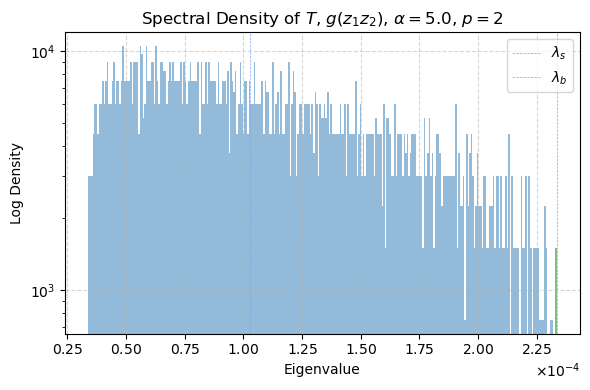

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter
from itertools import combinations
import pandas as pd

# ============ Step 1: 构造核估计的 T(y) ============
def compute_T_y_bessel(y_batch):
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)

# ============ Step 2: 构造谱矩阵 ============
def build_T_hat(X, T_y, center_X=True, gamma=0.0):
    n, d = X.shape
    if center_X:
        X = X - np.mean(X, axis=0)

    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n

    if gamma > 0:
        Cov = (X.T @ X) / n
        Cov_block = np.block([
            [Cov, Cov],
            [Cov, Cov]
        ])
        T_matrix += gamma * Cov_block

    return T_matrix

# ============ Step 3: 谱图绘制 ============
def plot_spectrum(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    bulk_color = '#2878B5'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1z_2)$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ============ Step 4: 对齐度量函数 ============
def orthonormalize(A):
    Q, _ = np.linalg.qr(A)
    return Q

def compute_alignment(W_hat, W_star):
    Q1 = orthonormalize(W_hat)
    Q2 = orthonormalize(W_star)
    overlap = Q1.T @ Q2
    u, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ============ Step 5: 单点和组合对齐分析 ============
def extract_W_from_eigenvectors(eigvecs, eigvals, z, X, W_star, p=2, label=None):
    d = X.shape[1]
    w_j = eigvecs[:, z]
    w_j = w_j.reshape((p, d)).T
    align_scores = []
    for j in range(p):
        score = max(np.abs(W_star.T @ w_j[:, j]))
        align_scores.append(score)
    return (label if label else f"eig{z}", eigvals[z], np.max(align_scores))

def extract_W_from_eigpair(eigvecs, eigvals, pair, X, W_star, p=2, label=None):
    d = X.shape[1]
    z1, z2 = pair
    w1 = eigvecs[:, z1].reshape((p, d)).T
    w2 = eigvecs[:, z2].reshape((p, d)).T
    W_hat = np.concatenate([w1, w2], axis=1)
    align_score = compute_alignment(W_hat, W_star)
    return (label if label else f"{z1}-{z2}", eigvals[z1], eigvals[z2], align_score)

def structural_alignment_analysis(eigvecs, eigvals, X, W_star, p=2):
    d = X.shape[1]
    top_indices = np.argsort(eigvals)[-8:]
    all_labels = [(f"eig{z}", z) for z in top_indices]

    results_single = []
    for label, z in all_labels:
        results_single.append(extract_W_from_eigenvectors(eigvecs.T, eigvals, z, X, W_star, p=p, label=label))
    df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
    print("\n=== Alignment Score for Individual Eigenvalues ===")
    print(df_single.sort_values(by="Alignment Score", ascending=False))

    results_pair = []
    for (label1, z1), (label2, z2) in combinations(all_labels, 2):
        pair_label = f"{label1}-{label2}"
        results_pair.append(extract_W_from_eigpair(eigvecs, eigvals, (z1, z2), X, W_star, p=p, label=pair_label))
    df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
    print("\n=== Alignment Score for Pairs of Eigenvalues ===")
    print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ============ Step 6: 主函数 ============
def main():
    d = 1000
    p = 2
    alpha = 5
    n = int(d * alpha)
    np.random.seed(42)

    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y, center_X=True, gamma=0.0)

    eigvals, eigvecs = eigh(T_hat)
    top_vectors = eigvecs[:, -p:]

    W_hat = np.zeros((d, p))
    for j in range(p):
        W_hat[:, j] = top_vectors[j * d:(j + 1) * d, j]
    alignment_score = compute_alignment(W_hat, W_star)
    print(f"\nSubspace alignment score: {alignment_score:.4f}")

    structural_alignment_analysis(eigvecs, eigvals, X, W_star, p=p)

    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum(eigvals, alpha=alpha, p=p, lambda_s=lambda_s, lambda_b=lambda_b)

if __name__ == "__main__":
    main()


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_43433/3680038713.py:61: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(eigvals_np), bins=100, alpha=0.6, label="Log Density")


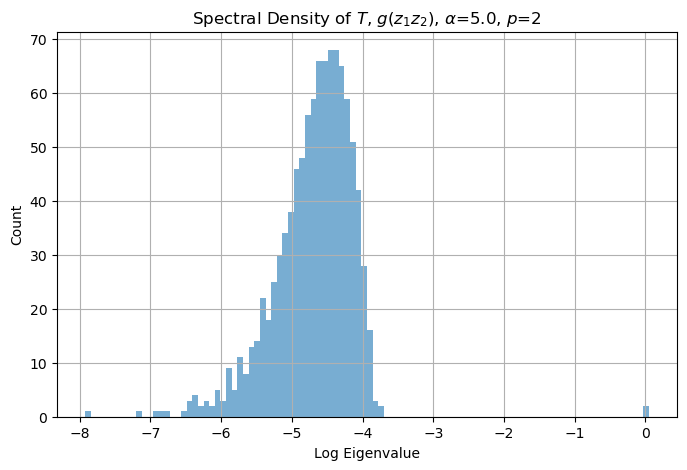

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 2000)

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import normalize
from scipy.stats import binned_statistic
import pandas as pd

# =================== Step 1: 数据构造 =================== #
n = 5000
d = 1000
p = 2
alpha = n / d
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Signal direction
W_star = torch.randn(d, p, device=device)
W_star = torch.linalg.qr(W_star)[0]  # 正交化

# Latent Z
Z = torch.randn(n, p, device=device)

# Linear feature X = Z W^T + noise
X = Z @ W_star.T + 0.01 * torch.randn(n, d, device=device)

# Nonlinear response y = g(z1,z2) = z1*z2
y = Z[:, 0] * Z[:, 1]

# =================== Step 2: 构造 T(y) 矩阵 =================== #
def Bessel_preprocessing(y):
    y = y.cpu().numpy()
    T = []
    for val in y:
        zzT = np.zeros((2, 2))
        zzT[0, 1] = zzT[1, 0] = val  # Only E[z1z2] is non-zero
        T.append(zzT)
    return torch.tensor(np.array(T), dtype=torch.float32, device=device)

T_y = Bessel_preprocessing(y)

# =================== Step 3: 构造对称谱矩阵 =================== #
L = torch.zeros((p * d, p * d), device=device)

for i in range(n):
    xi = X[i].reshape(-1, 1)  # (d, 1)
    Ti = T_y[i]               # (p, p) = (2, 2)
    kron = torch.kron(xi, torch.eye(p, device=device))  # shape: (pd, p)
    L += kron @ Ti @ kron.T


L /= n

# =================== Step 4: 谱分解与可视化 =================== #
eigvals, eigvecs = torch.linalg.eigh(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# 绘图
plt.figure(figsize=(8, 5))
plt.hist(np.log10(eigvals_np), bins=100, alpha=0.6, label="Log Density")
plt.xlabel("Log Eigenvalue")
plt.ylabel("Count")
plt.title(rf"Spectral Density of $T$, $g(z_1z_2)$, $\alpha$={alpha}, $p$={p}")
plt.grid(True)
plt.show()

# =================== Step 5: 计算对齐得分 =================== #
def compute_alignment_score(U_est, W_true):
    # Subspace alignment: Tr((U^T W)(W^T U)) = sum(singular values)^2 / p
    M = U_est.T @ W_true.cpu().numpy()
    return np.linalg.norm(M, ord='fro')**2 / p

U_top = eigvecs_np[:, -p:]  # 取最大的p个特征向量
score_subspace = compute_alignment_score(U_top, W_star)
print(f"Subspace alignment score: {score_subspace:.4f}")

# ========== 单点对齐 ==========
all_labels = []
for idx in range(-8, 0):
    label = f"eig{len(eigvals_np) + idx}"
    vec = eigvecs_np[:, idx]
    all_labels.append((label, vec))

results_single = []
for label, vec in all_labels:
    align = compute_alignment_score(vec.reshape(-1, 1), W_star)
    results_single.append([label, eigvals_np[int(label[3:])], align])

df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# ========== 双点组合对齐 ==========
results_pair = []
for (label1, vec1), (label2, vec2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    W_est = np.stack([vec1, vec2], axis=1)
    align = compute_alignment_score(W_est, W_star)
    λ1 = eigvals_np[int(label1[3:])]
    λ2 = eigvals_np[int(label2[3:])]
    results_pair.append([pair_label, λ1, λ2, align])

df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))


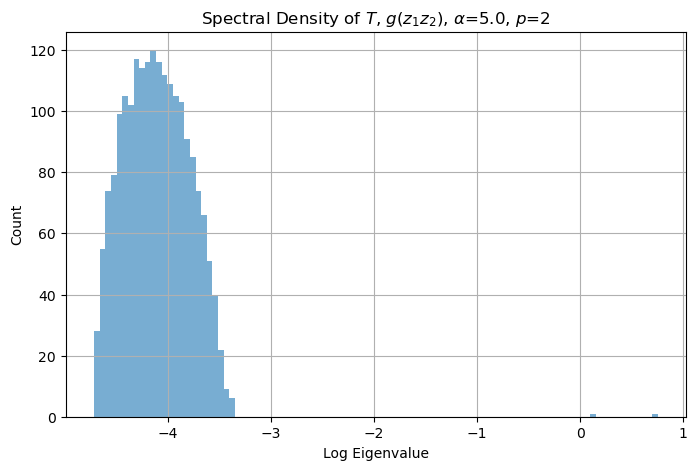

Subspace alignment score: 0.0040

=== Alignment Score for Individual Eigenvalues ===
      Type         λ  Alignment Score
0  eig1992  0.000396         0.000002
1  eig1993  0.000396         0.002323
2  eig1994  0.000420         0.001648
3  eig1995  0.000425         0.002894
4  eig1996  0.000426         0.001733
5  eig1997  0.000433         0.000211
6  eig1998  1.387823         0.002920
7  eig1999  5.653868         0.001044

=== Alignment Score for Pairs of Eigenvalues ===
               Pair        λ1        λ2  Alignment Score
20  eig1995-eig1998  0.000425  1.387823         0.005814
11  eig1993-eig1998  0.000396  1.387823         0.005243
8   eig1993-eig1995  0.000396  0.000425         0.005217
23  eig1996-eig1998  0.000426  1.387823         0.004653
18  eig1995-eig1996  0.000425  0.000426         0.004627
16  eig1994-eig1998  0.000420  1.387823         0.004569
13  eig1994-eig1995  0.000420  0.000425         0.004543
9   eig1993-eig1996  0.000396  0.000426         0.004055
7   eig199

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import normalize
from scipy.stats import binned_statistic
import pandas as pd

# =================== Step 1: 数据构造 =================== #
n = 5000
d = 1000
p = 2
alpha = n / d
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Signal direction
# 构造匹配 z1*z2 的方向：e.g., w1+w2, w1−w2
w = torch.randn(d, device=device)
w = w / torch.norm(w)
W_star = torch.stack([w, w], dim=1)  # w1 = w2 = same direction


# Latent Z
Z = torch.randn(n, p, device=device)

# Linear feature X = Z W^T + noise
X = Z @ W_star.T + 0.01 * torch.randn(n, d, device=device)

# Nonlinear response y = g(z1,z2) = z1*z2
y = Z[:, 0] * Z[:, 1]

# =================== Step 2: 构造 T(y) 矩阵 =================== #
from scipy.special import kv as K_v

def Bessel_T_y_exact(y_tensor):
    y_np = y_tensor.detach().cpu().numpy()
    T_list = []

    for y in y_np:
        abs_y = np.abs(y)
        if abs_y == 0:
            ratio = 1.0  # Use limit: K1/K0 → 1 as y → 0+
        else:
            K1 = K_v(1, abs_y)
            K0 = K_v(0, abs_y)
            ratio = K1 / K0 if K0 != 0 else 1.0  # avoid division by zero

        mu = abs_y * ratio
        T = np.array([[mu, y],
                      [y, mu]])
        T_list.append(T)

    return torch.tensor(np.array(T_list), dtype=torch.float32, device=y_tensor.device)


T_y = Bessel_T_y_exact(y)


# =================== Step 3: 构造对称谱矩阵 =================== #
L = torch.zeros((p * d, p * d), device=device)

for i in range(n):
    xi = X[i].reshape(-1, 1)  # (d, 1)
    Ti = T_y[i]               # (p, p) = (2, 2)
    kron = torch.kron(xi, torch.eye(p, device=device))  # shape: (pd, p)
    L += kron @ Ti @ kron.T

L /= n

# =================== Step 4: 谱分解与可视化 =================== #
eigvals, eigvecs = torch.linalg.eigh(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# 绘图
plt.figure(figsize=(8, 5))
plt.hist(np.log10(eigvals_np), bins=100, alpha=0.6, label="Log Density")
plt.xlabel("Log Eigenvalue")
plt.ylabel("Count")
plt.title(rf"Spectral Density of $T$, $g(z_1z_2)$, $\alpha$={alpha}, $p$={p}")
plt.grid(True)
plt.show()

# =================== Step 5: 计算对齐得分 =================== #
# 构造真实展开子空间 W_true_expanded ∈ ℝ^{pd × p}
W_star_np = W_star.cpu().numpy()
I_p = np.eye(p)
W_true_expanded = np.kron(I_p, W_star_np)  # shape: (pd, p)


def compute_alignment_score(U_est, W_true):
    # Subspace alignment: Tr((U^T W)(W^T U)) = sum(singular values)^2 / p
    M = U_est.T @ W_true
    return np.linalg.norm(M, ord='fro')**2 / p

# 主子空间对齐得分
U_top = eigvecs_np[:, -p:]  # 取最大的p个特征向量
score_subspace = compute_alignment_score(U_top, W_true_expanded)
print(f"Subspace alignment score: {score_subspace:.4f}")

# ========== 单点对齐 ==========
all_labels = []
for idx in range(-8, 0):
    label = f"eig{len(eigvals_np) + idx}"
    vec = eigvecs_np[:, idx]
    all_labels.append((label, vec))

results_single = []
for label, vec in all_labels:
    align = compute_alignment_score(vec.reshape(-1, 1), W_true_expanded)
    results_single.append([label, eigvals_np[int(label[3:])], align])

df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# ========== 双点组合对齐 ==========
results_pair = []
for (label1, vec1), (label2, vec2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    W_est = np.stack([vec1, vec2], axis=1)
    align = compute_alignment_score(W_est, W_true_expanded)
    λ1 = eigvals_np[int(label1[3:])]
    λ2 = eigvals_np[int(label2[3:])]
    results_pair.append([pair_label, λ1, λ2, align])

df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))


In [26]:
from sklearn.metrics.pairwise import cosine_similarity

U_top_torch = torch.tensor(U_top, dtype=torch.float32)
vec1 = U_top_torch[:, 0].reshape(p, d).T  # d × p
vec2 = U_top_torch[:, 1].reshape(p, d).T

sim_matrix = cosine_similarity(vec1.T, W_star.cpu().numpy().T)
print("Cosine similarity between recovered and W_star directions:")
print(np.round(sim_matrix, 3))


Cosine similarity between recovered and W_star directions:
[[ 0.021 -0.035]
 [-0.032  0.009]]


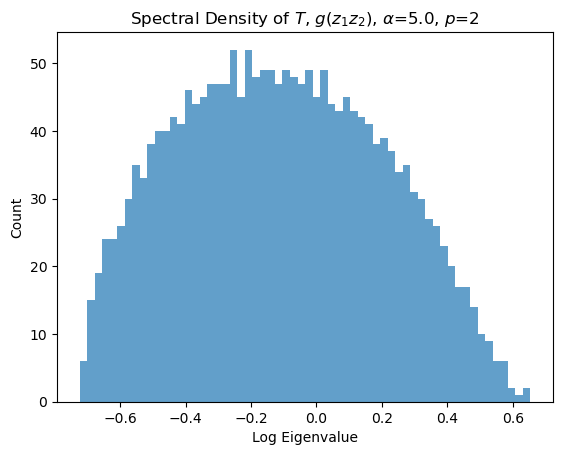

Subspace alignment score: 0.3598
Cosine similarity matrix:
 [[0.45  0.416]
 [0.416 0.414]]


In [32]:
import torch
import numpy as np
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# ========== Parameters ==========
n, d, p = 5000, 1000, 2  # 可调大后测试
alpha = n / d
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(0)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using Bessel approximation ==========
def construct_T_y(y_i):
    abs_y = np.abs(y_i) + 1e-8
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / K0)
    return torch.tensor([[r, y_i], [y_i, r]], dtype=torch.float32)

I2 = torch.eye(2)
T_hat = torch.zeros((2*d, 2*d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # shape: (2d, 2)
    T_yi = construct_T_y(y[i])    # shape: (2, 2)
    T_hat += kron_x @ T_yi @ kron_x.T

T_hat /= n

# ========== Step 3: Spectral Decomposition ==========
eigvals, eigvecs = torch.linalg.eigh(T_hat)
top_vals, indices = torch.topk(eigvals, p)
U_top = eigvecs[:, indices]  # shape: (2d, p)

# ========== Step 4: Compute Alignment ==========
U_top = U_top.numpy()
U_top_reshaped = U_top.reshape(d, 2, p, order='F').sum(axis=1)  # (d, p)

W_np = W_star.numpy()
sim_matrix = cosine_similarity(U_top_reshaped.T, W_np.T)
subspace_score = np.linalg.norm(sim_matrix, 'fro')**2 / p

# ========== Step 5: Plot Spectrum ==========
plt.hist(np.log10(eigvals.numpy()), bins=60, alpha=0.7)
plt.title(f"Spectral Density of $T$, $g(z_1z_2)$, $\\alpha$={alpha:.1f}, $p$={p}")
plt.xlabel("Log Eigenvalue")
plt.ylabel("Count")
plt.show()

print("Subspace alignment score:", round(subspace_score, 4))
print("Cosine similarity matrix:\n", np.round(sim_matrix, 3))


In [36]:
def compute_alignment_scores_from_2d(eig_vals, eig_vecs, W_star, top_k=8):
    """
    eig_vecs: numpy array, shape (2d, 2d), 每列为特征向量
    W_star: torch.Tensor, shape (d, p)
    返回：每个主特征值及其组合对应的对齐度
    """
    d = W_star.shape[0]
    p = W_star.shape[1]
    indices = np.argsort(eig_vals)[-top_k:]
    scores = []

    for i in indices:
        v = eig_vecs[:, i]  # shape (2d,)
        v_reshaped = v.reshape(d, 2, order='F').sum(axis=1)  # (d,)
        v_torch = torch.tensor(v_reshaped[:, None], dtype=torch.float32)  # (d, 1)
        align_score = torch.norm(W_star.T @ v_torch).item()
        scores.append((f"eig{i}", eig_vals[i], align_score))

    pair_scores = []
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            v1 = eig_vecs[:, indices[i]].reshape(d, 2, order='F').sum(axis=1)
            v2 = eig_vecs[:, indices[j]].reshape(d, 2, order='F').sum(axis=1)
            V = np.stack([v1, v2], axis=1)  # shape (d, 2)
            Q, _ = np.linalg.qr(V)
            Q_torch = torch.tensor(Q, dtype=torch.float32)
            proj = Q_torch @ Q_torch.T @ W_star
            align_score = torch.norm(proj).item()
            pair_scores.append((
                f"eig{indices[i]}+eig{indices[j]}",
                (eig_vals[indices[i]], eig_vals[indices[j]]),
                align_score
            ))

    return pd.DataFrame(scores, columns=["Type", "λ", "Alignment Score"]), \
           pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
eigvals_np = eigvals.numpy()
eigvecs_np = eigvecs.numpy()
individual_df, pair_df = compute_alignment_scores_from_2d(eigvals_np, eigvecs_np, W_star)

print("\n=== Individual Alignment Scores ===")
print(individual_df.round(5))

print("\n=== Pairwise Alignment Scores ===")
print(pair_df.round(5))



=== Individual Alignment Scores ===
      Type        λ  Alignment Score
0  eig1992  3.73003          0.00000
1  eig1993  3.76926          0.00000
2  eig1994  3.77519          0.17288
3  eig1995  3.87058          0.07531
4  eig1996  3.93562          0.18225
5  eig1997  4.11311          0.00000
6  eig1998  4.46686          0.00000
7  eig1999  4.50503          0.86615

=== Pairwise Alignment Scores ===
               Type                  λ Pair  Alignment Score
0   eig1992+eig1993   (3.730026, 3.7692595)          0.14751
1   eig1992+eig1994   (3.730026, 3.7751896)          0.15202
2   eig1992+eig1995    (3.730026, 3.870582)          0.11999
3   eig1992+eig1996    (3.730026, 3.935615)          0.16960
4   eig1992+eig1997   (3.730026, 4.1131077)          0.11331
5   eig1992+eig1998   (3.730026, 4.4668584)          0.59043
6   eig1992+eig1999   (3.730026, 4.5050254)          0.62197
7   eig1993+eig1994  (3.7692595, 3.7751896)          0.14653
8   eig1993+eig1995   (3.7692595, 3.870582)   

In [46]:

def compute_alignment_scores_from_2d(eig_vals, eig_vecs, W_star, top_k=8):
    """
    Parameters:
    - eig_vals: numpy array of eigenvalues, shape (2d,)
    - eig_vecs: numpy array of eigenvectors, shape (2d, 2d)
    - W_star: torch.Tensor of true subspace in ℝ^d, shape (d, p)
    
    Returns:
    - individual_df: DataFrame of individual eigenvector alignment scores
    - pair_df: DataFrame of pairwise (2-eigenvector span) alignment scores
    """

    d, p = W_star.shape

    # Step 1: 对称拼接 ground-truth W_star → 2d × 2p
    W_star_sym = np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),   # [W, 0]
        np.hstack([np.zeros_like(W_star), W_star])    # [0, W]
    ])  # shape: (2d, 2p)
    W_star_sym = torch.tensor(W_star_sym, dtype=torch.float32)
    W_normed = W_star_sym / torch.norm(W_star_sym, dim=0, keepdim=True)  # shape: (2d, 2p)

    # Step 2: 取最大的 top_k 特征值及其向量
    indices = np.argsort(eig_vals)[-top_k:]

    # === Individual Scores ===
    individual_scores = []
    for i in indices:
        vec = eig_vecs[:, i]
        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()  # 最大余弦值
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    # === Pairwise Span Scores ===
    pair_scores = []
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            vi = eig_vecs[:, indices[i]]
            vj = eig_vecs[:, indices[j]]
            V = np.stack([vi, vj], axis=1)  # shape (2d, 2)
            Q, _ = np.linalg.qr(V)  # 正交化
            Q_torch = torch.tensor(Q, dtype=torch.float32)
            proj = Q_torch @ Q_torch.T @ W_star_sym  # 投影 ground-truth 到 Q 的子空间
            align_score = torch.norm(proj).item()
            λ_pair = (eig_vals[indices[i]], eig_vals[indices[j]])
            pair_scores.append((f"eig{indices[i]}+eig{indices[j]}", λ_pair, align_score))

    # 封装 DataFrame
    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])

    return individual_df, pair_df







eigvals_np = eigvals.numpy()
eigvecs_np = eigvecs.numpy()
individual_df, pair_df = compute_alignment_scores_from_2d(eigvals_np, eigvecs_np, W_star)

print("\n=== Individual Alignment Scores ===")
print(individual_df.round(5))

print("\n=== Pairwise Alignment Scores ===")
print(pair_df.round(5))



=== Individual Alignment Scores ===
      Type        λ  Alignment Score
0  eig1992  3.73003          0.09553
1  eig1993  3.76926          0.04094
2  eig1994  3.77519          0.06546
3  eig1995  3.87058          0.02861
4  eig1996  3.93562          0.06506
5  eig1997  4.11311          0.22305
6  eig1998  4.46686          0.20468
7  eig1999  4.50503          0.31815

=== Pairwise Alignment Scores ===
               Type                  λ Pair  Alignment Score
0   eig1992+eig1993   (3.730026, 3.7692595)          0.18497
1   eig1992+eig1994   (3.730026, 3.7751896)          0.21278
2   eig1992+eig1995    (3.730026, 3.870582)          0.18212
3   eig1992+eig1996    (3.730026, 3.935615)          0.21666
4   eig1992+eig1997   (3.730026, 4.1131077)          0.47470
5   eig1992+eig1998   (3.730026, 4.4668584)          0.43992
6   eig1992+eig1999   (3.730026, 4.5050254)          0.63674
7   eig1993+eig1994  (3.7692595, 3.7751896)          0.13720
8   eig1993+eig1995   (3.7692595, 3.870582)   

In [54]:
import numpy as np
import pandas as pd
import torch
from itertools import combinations


def elevate_W_star_to_symmetric(W_star):
    """
    构造对称形式的 ground truth W_star ∈ ℝ^{2d×2p}
    """
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),   # [W, 0]
        np.hstack([np.zeros_like(W_star), W_star])    # [0, W]
    ])  # shape = (2d, 2p)


def elevate_vector(v, position='top', d=None):
    """
    将 d 维向量升维为 2d：
    - position = 'top': [v, 0]
    - position = 'bottom': [0, v]
    """
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])


def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    """
    统一评估谱估计器输出特征向量与真实子空间的对齐情况

    Parameters:
    - eig_vals: numpy array of eigenvalues (L,)
    - eig_vecs: numpy array of eigenvectors (L, L)
    - W_star: torch.Tensor, ground-truth subspace ∈ ℝ^{d×p}
    - top_k: int, number of top eigenvectors to evaluate
    - mode: 'symmetric' or 'asymmetric'

    Returns:
    - individual_df, pair_df: pd.DataFrame
    """

    d, p = W_star.shape
    L = eig_vecs.shape[0]  # 应为 2d（对称）或 d（非对称）

    # Step 1: 构造对称形式的 W_star ∈ ℝ^{2d×2p}
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
    W_normed = W_sym / torch.norm(W_sym, dim=0, keepdim=True)

    # Step 2: 选择 top_k 特征值对应的索引
    indices = np.argsort(eig_vals)[-top_k:]

    # === Individual Scores ===
    individual_scores = []
    for i in indices:
        vec = eig_vecs[:, i]

        # 如果是非对称谱估计器，则需要升维
        if mode == 'asymmetric':
            vec = elevate_vector(vec, position='top', d=d)

        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    # === Pairwise Alignment Scores ===
    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]

        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)

        V = np.stack([vi, vj], axis=1)  # shape: (2d, 2)
        Q, _ = np.linalg.qr(V)  # 正交化
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = torch.norm(proj).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    # 封装结果
    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df


# 对称谱估计器输出
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)  # 或其他你已有的对称谱矩阵

# 转为 numpy
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

# 统一评估
individual_df, pair_df = evaluate_alignment_unified(eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric')


NameError: name 'L_sym' is not defined